# Tensors and gradients

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Tensors (https://www.tensorflow.org/guide/tensor)

Tensors are multi-dimensional arrays with a uniform type, similar to numpy arrays

In [10]:
tensor1 = tf.constant(4)
print('\ntensor1: ',tensor1)

tensor2 = tf.constant([1.0,2.0,3.0])
print('\ntensor2: ',tensor2)

tensor3 = tf.constant([[1.0,2.0,3.0],[3.4,1.0,1.0]])
print('\ntensor3: ',tensor3)

tensor4 = tf.linspace(0,1,10)
print('\ntensor4: ',tensor4)


tensor1:  tf.Tensor(4, shape=(), dtype=int32)

tensor2:  tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)

tensor3:  tf.Tensor(
[[1.  2.  3. ]
 [3.4 1.  1. ]], shape=(2, 3), dtype=float32)

tensor4:  tf.Tensor(
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ], shape=(10,), dtype=float64)


Tensors can be converted to numpy arrays

In [11]:
tensor4_np = tensor4.numpy()
print('\ntensor4 converted numpy array: ',tensor4_np)
print('\ntype: ',type(tensor4_np))


tensor4 converted numpy array:  [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]

type:  <class 'numpy.ndarray'>


 All tensors are immutable like Python numbers and strings: you can never update the contents of a tensor, only create a new one.

In [12]:
print('6th element of tensor4: ',tensor4[5].numpy())
tensor4[5] = 100.0

6th element of tensor4:  0.5555555555555556


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

## Variables (https://www.tensorflow.org/guide/variable)

A variable is a tensor whose value can be changed by running operations on it

In [13]:
var1 = tf.Variable(4)
print('\nvar1: ',var1)

var2 = tf.Variable(tensor2)
print('\nvar2: ',var2)

var3 = tf.Variable(tf.linspace(0,1,10))
print('\nvar3: ',var3)


var1:  <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=4>

var2:  <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

var3:  <tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])>


After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.

In [14]:
var4 = tf.Variable([1.0,2.0])
print('\nvar4: ', var4.numpy())

var4.assign([3.0,4.0])
print('\nmodified var4: ',var4.numpy())

var4.assign_add([1.0,2.0])
print('\nmodified var4: ',var4.numpy())

var4.assign_sub([1.0,2.0])
print('\nmodified var4: ',var4.numpy())

print('\nrecall that the shape is fixed')
var4.assign([3.0,4.0,4.0])


var4:  [1. 2.]

modified var4:  [3. 4.]

modified var4:  [4. 6.]

modified var4:  [3. 4.]

recall that the shape is fixed


ValueError: Cannot assign value to variable ' Variable:0': Shape mismatch.The variable shape (2,), and the assigned value shape (3,) are incompatible.

## Gradients in Tensorflow:

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.

We use the `tf.GradientTape` api for this, see detailed guide here https://www.tensorflow.org/guide/autodiff

### Differentiating wrt a scalar variable

$$
x = 4, \qquad y = x^2, \qquad z = 2 y
$$

Then

$$
\frac{dz}{dx} = 2 \frac{d y}{d x} = 2 (2 x)
$$

In [15]:
x = tf.Variable(4.0)
print(' x:',x)

with tf.GradientTape() as tape:
    y = x**2
    z = 2*y

print(f'\n y:', y) # NOTE THE OBJECT TYPE
print(f'\n z:', z)

dz_dx = tape.gradient(z, x)  # Evaluate gradient
print(f'\n dz_dx:',dz_dx.numpy())

 x: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.0>

 y: tf.Tensor(16.0, shape=(), dtype=float32)

 z: tf.Tensor(32.0, shape=(), dtype=float32)

 dz_dx: 16.0


### Differentiating wrt a scalar tensor (not a variable)

In [16]:
x = tf.constant(4.0)
print(' x:',x)

with tf.GradientTape() as tape:
    y = x**2
    z = 2*y

dz_dx = tape.gradient(z, x)  # Evaluate gradient
print(f'\n dz_dx:',dz_dx)

 x: tf.Tensor(4.0, shape=(), dtype=float32)

 dz_dx: None


### To differentiate wrt a tensor x, it needs to be watched by the tape

In [17]:
x = tf.constant(4.0)
print(' x:',x)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2
    z = 2*y

dz_dx = tape.gradient(z, x)  # Evaluate gradient
print(f'\n dz_dx:',dz_dx)

 x: tf.Tensor(4.0, shape=(), dtype=float32)

 dz_dx: tf.Tensor(16.0, shape=(), dtype=float32)


## Non-persistant vs persistent tapes

By default, the tape is deleted after a single call to tape.gradient()

In [18]:
x = tf.Variable(4.0)
with tf.GradientTape() as tape:
    y = x**2
    z = 2*y

dz_dx = tape.gradient(z, x) #(4 * x)
print(f'\n dz_dx:',dz_dx)  
dy_dx = tape.gradient(y, x)  #(2 * x)


 dz_dx: tf.Tensor(16.0, shape=(), dtype=float32)


RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

### Option 1: Use a persistant tape

In [19]:
x = tf.Variable(4.0)
with tf.GradientTape(persistent=True) as tape:
    y = x**2
    z = 2*y

dz_dx = tape.gradient(z, x) #(4 * x)
print(f'\n dz_dx:',dz_dx)  
dy_dx = tape.gradient(y, x)  #(2 * x)
print(f'\n dy_dx:',dy_dx)

del tape # Clearing the tape, since it doesn't happen automatically now


 dz_dx: tf.Tensor(16.0, shape=(), dtype=float32)

 dy_dx: tf.Tensor(8.0, shape=(), dtype=float32)


### Option 2: use nested tapes

In [20]:
x = tf.Variable(4.0)
with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      y = x**2
      z = 2*y
    dz_dx = tape2.gradient(z, x)  # Tape 2 gets deleted after this call
dy_dx = tape1.gradient(y, x)      # Tape 1 gets deleted after this call
print(f'\n dz_dx:',dz_dx) 
print(f'\n dy_dx:',dy_dx)  


 dz_dx: tf.Tensor(16.0, shape=(), dtype=float32)

 dy_dx: tf.Tensor(8.0, shape=(), dtype=float32)


## Higher-order derivates

We can use this strategy to evalaute higher-order derivates.

In [21]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      y = x**4
    dy_dx = tape2.gradient(y, x)      # 4*x**3
d2y_dx2 = tape1.gradient(dy_dx, x)    # 12*x**2
print(f'\n dy_dx:',dy_dx) 
print(f'\n d2y_dx2:',d2y_dx2) 


 dy_dx: tf.Tensor(32.0, shape=(), dtype=float32)

 d2y_dx2: tf.Tensor(48.0, shape=(), dtype=float32)


## Differentiating a tensor wrt to a tensor

Say $ x \in \mathbb{R}^d$ and $y \in \mathbb{R}^D$, then

$$
g := grad(y,x) \in \mathbb{R}^d
$$ 

with 

$$
g_i = \sum_{j=1}^D \frac{\partial y_j}{\partial x_i}
$$

In the following example

$$x = \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}= \begin{bmatrix}2.0\\3.0\\4.0\end{bmatrix}, \quad A = \begin{bmatrix} 1.0 & 2.0 & 0.0 \\ 1.0 & 1.0 & -1.0\end{bmatrix}, \quad y = Ax = \begin{bmatrix}x_1 + 2x_2\\x_1 + x_2-x_3\end{bmatrix} = \begin{bmatrix}8\\1\end{bmatrix}$$

$$\frac{d y}{d x} = \begin{bmatrix}1 & 1\\2 & 1 \\0 & -1\end{bmatrix}^\top \quad \implies grad(y,x) = \begin{bmatrix}2\\3 \\-1\end{bmatrix}$$

In [22]:
x = tf.Variable([[2.0],[3.0],[4.0]])
A = tf.constant([[1.0,2.0,0.0],[1.0,1.0,-1.0]])

with tf.GradientTape() as tape:
  y = tf.matmul(A,x)

print('\nx: ',x.numpy())
print('\ny: ',y.numpy())

grad = tape.gradient(y, x)
print('\ngrad(y,x): ',grad.numpy())


x:  [[2.]
 [3.]
 [4.]]

y:  [[8.]
 [1.]]

grad(y,x):  [[ 2.]
 [ 3.]
 [-1.]]


To revaluate the full Jacobian, we need to use tape.jacobian (https://www.tensorflow.org/guide/advanced_autodiff#jacobians)

Note that since x in the example below is a tensor of size 3x1 and y is a tensor of size 2x1, the Jacobian is a tensor of size 2x1x3x1. 

In [23]:
x = tf.Variable([[2.0],[3.0],[4.0]])
A = tf.constant([[1.0,2.0,0.0],[1.0,1.0,-1.0]])

with tf.GradientTape() as tape:
  y = tf.matmul(A,x)

print('\nx: ',x.numpy())
print('\ny: ',y.numpy())

jac = tape.jacobian(y, x)
print('\ndydx: ',jac.numpy())
print('\ndydx is a tensor of shape: ',jac.shape)
print('\nsqueezed dydx: ',tf.squeeze(jac).numpy())


x:  [[2.]
 [3.]
 [4.]]

y:  [[8.]
 [1.]]

dydx:  [[[[ 1.]
   [ 2.]
   [ 0.]]]


 [[[ 1.]
   [ 1.]
   [-1.]]]]

dydx is a tensor of shape:  (2, 1, 3, 1)

squeezed dydx:  [[ 1.  2.  0.]
 [ 1.  1. -1.]]


2022-10-27 12:01:06.226334: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent. Another way to say this is that the Jacobian is a diagonal matrix.

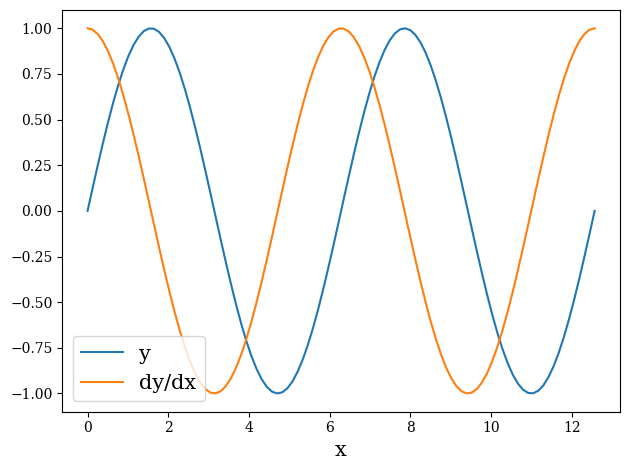

In [25]:
x = tf.linspace(0.0, 4*np.pi, 100)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.math.sin(x)

dy_dx = tape.gradient(y,x)

plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend(loc='lower left',fontsize=15);
plt.xlabel('x',fontsize=15);

### Gradients of ReLU

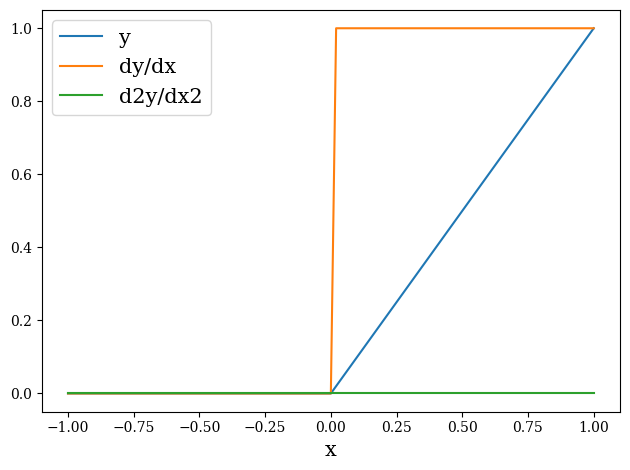

In [26]:
x = tf.linspace(-1,1, 101)

with tf.GradientTape() as tape1:
    tape1.watch(x)
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        y = tf.nn.relu(x)
    dy_dx = tape2.gradient(y,x)
d2y_dx2 = tape1.gradient(dy_dx,x)    

plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.plot(x, d2y_dx2, label='d2y/dx2')
plt.legend(loc='upper left',fontsize=15);
plt.xlabel('x',fontsize=15);